In [1]:
import math
import numpy as np
from torch import nn
from torch.nn import init
from torch.nn.modules import loss
import torch

In [2]:
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline  

## Восставновление матрицы малого ранга (2 балла)

Есть неизвестная матрица X_taget. (В тетрадке она хранятся явно, для самопроверки)
X_noised - зашумленная матрица, по которой нужно восстановить X_taget.

Для решения задачи. Нужно задать две матрицы $H$, $W$ и найти минимум $|| W * H = X_{noisy} ||$ методом градиентного спуска.

Напишите градиетный спуск и подберите learning rate и количетсво итераций. 

In [3]:
def get_X():
    np.random.seed(12345)
    W_ = np.random.randn(73, 6)
    H_ = np.random.randn(6, 46)
    X_taget = W_.dot(H_)
    return torch.tensor(X_taget), torch.tensor(X_taget + np.random.randn(73, 46) * 0.1)

In [4]:
X_taget, X_noisy = get_X()

In [5]:
def dist(X1, X2):
    d = (X1 - X2) ** 2
    return d.mean()

In [6]:
# Минимизируейте dist(X_taget, W.matmul(H))

In [7]:
W = torch.tensor(np.random.randn(73, 6), requires_grad=True)
H = torch.tensor(np.random.randn(6, 46), requires_grad=True)
F = W.matmul(H)

dist(F, X_noisy)

tensor(10.9638, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [8]:
lr = 0.1
iters = 10000

for i in range(iters):
    W.grad = None
    H.grad = None
    
    F = W.matmul(H)
        
    loss = dist(F, X_noisy)
    loss.backward()
    
    if i % 1000 == 0:
        print(f"loss = {loss.detach()}")
            
    with torch.no_grad():
        W -= lr * W.grad
        H -= lr * H.grad

loss = 10.963772331890139
loss = 1.4836832653212264
loss = 0.22089013566574656
loss = 0.06624548327147974
loss = 0.019356538845063224
loss = 0.009913195401148552
loss = 0.008199733836524932
loss = 0.007895210796215175
loss = 0.007841305431032227
loss = 0.007831770418296689


In [9]:
base_dist = dist(X_noisy, X_taget).item()
recoverd_dist = dist(W.matmul(H), X_taget).item()

In [10]:
# Восстановленая матрица должна быть ближе к исходной чем шумная
print(f"Distance to noisy matrix:     {base_dist}")
print(f"Distance to recovered matrix: {recoverd_dist}")

Distance to noisy matrix:     0.010014712528201112
Distance to recovered matrix: 0.002186248867688226


In [11]:
assert recoverd_dist < base_dist

## Эластичная веревка (4 балла)

Эластичная веревка свободно провисает между двумя опорами. Нужно смоделировать какую форму примет веревка.

Представим веревку как набор одинаковых грузов, соединенных невесомыми пружинами. Нам требуется найти такое положение грузов, в котором суммарная потенциальная энергия будет минимальна.

Потенциальная энергия груза зависит от высоты:

$$ E^m_i = mgh_i = mgy_i $$

Потенциальная энергия пружины зависит от расстояния между соседним грузами $ d_{i, i+1} $

$$ E^s_{i,i+1} = k (d_{i, i+1} - d_0) ^ 2 / 2 $$

Запишите выражение для энергии и найдите минимум методом градиентного спуска. (Не забудьте, что крайние грузы зафиксированы их положение всегда равно начальному)

Ниже заданы все необходимые константы:
* `g` - ускорение свободного падения $g$
* `x_start`, `y_start` - начальные координаты грузов
* `start_dist` - длина пружины с свобдном состоянии $d_0$
* `k` - коэффициент упругости пружины $k$
* `mass` - масса груза $m$

In [12]:
# 
joints_number = 40

g = 9.81 # м/с2

x_start = np.linspace(0, 1, num=joints_number + 1) 
y_start = np.zeros(joints_number + 1)

start_dist = 1 / joints_number # м

k = 1 * joints_number # Н/м

mass = 0.01 / (joints_number + 1) # кг

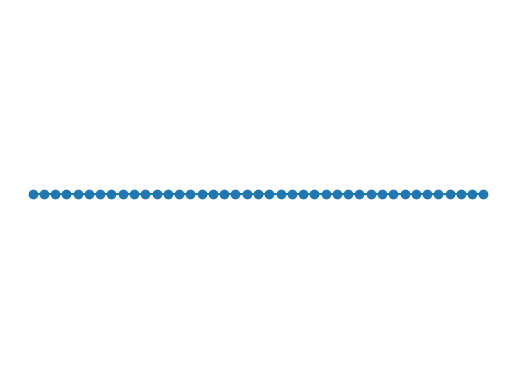

In [13]:
plt.axis("off")
plt.plot(x_start, y_start, marker='o')
plt.show()

In [14]:
x = torch.tensor(x_start, requires_grad=True, dtype=torch.float32)
y = torch.tensor(y_start, requires_grad=True, dtype=torch.float32)

In [15]:
def E_mass(x, y):
    return torch.sum(mass * g * y)

In [16]:
def E_springs(x, y):
    return torch.sum(k / 2 * (((torch.sqrt((x[:-1] - x[1:]) ** 2 + (y[:-1] - y[1:]) ** 2) - start_dist)) ** 2))

In [17]:
def E(x, y):    
    return E_mass(x, y) + E_springs(x, y)

In [18]:
E(x, y)

tensor(3.7512e-13, grad_fn=<AddBackward0>)

In [19]:
lr = 0.01
iters = 10000

for i in range(iters):
    x.grad = None
    y.grad = None
        
    loss = E(x, y)
    loss.backward()
    
    if i % 1000 == 0:
        print(f"loss = {loss.detach()}")
            
    with torch.no_grad():
        x[1:-1] -= lr * x.grad[1:-1]
        y[1:-1] -= lr * y.grad[1:-1]
        

loss = 3.7511660444522477e-13
loss = -0.002097569638863206
loss = -0.0038495303597301245
loss = -0.0052549694664776325
loss = -0.006319548934698105
loss = -0.007055342197418213
loss = -0.007503957487642765
loss = -0.00774396164342761
loss = -0.007859132252633572
loss = -0.007910218089818954


In [20]:
# Получите суммарную энергию меньше -0.007

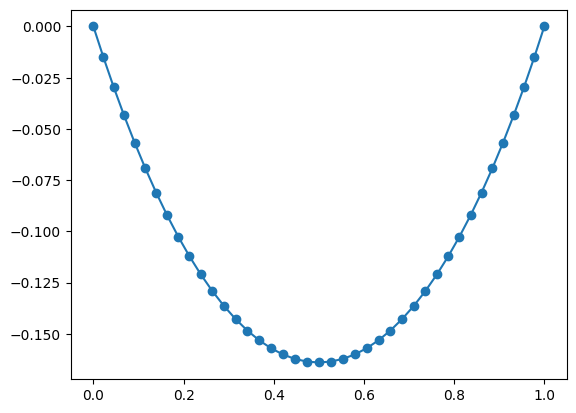

In [21]:
plt.plot(x.detach().numpy(), y.detach().numpy(), marker='o')
plt.show()